### Implementation of Content-based Filtering

In [128]:
import pandas as pd
import numpy as np
import time
import math
from math import sqrt
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
from xgboost import XGBRegressor
import pickle

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
random.seed(42)


In [2]:
data_folder = 'data/'
user_item_ratings_reduced = pd.read_csv(f'{data_folder}user_ratings_reduced.csv')
user_item_ratings_reduced = user_item_ratings_reduced.drop(columns=["Unnamed: 0"])
item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
item_info = pd.read_csv(data_folder + 'games.csv')
item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
item_themes = pd.read_csv(data_folder + 'themes.csv')

In [3]:
# user_item_ratings_reduced['rating'] = user_item_ratings_reduced['rating'].round(0).astype(int)

In [4]:
user_item_rating_count = user_item_ratings_reduced.groupby('user').count()

In [5]:
min_rating_count = 10
user_rating_count = user_item_rating_count[user_item_rating_count['rating'] >= min_rating_count]
user_list_filtered = list(user_rating_count.index)
user_item_ratings_filtered = user_item_ratings_reduced[user_item_ratings_reduced['user'].isin(user_list_filtered)]

In [8]:
user_item_ratings_filtered.head()

,item,rating,user
1,203416,8.0,-=Yod@=-
2,271896,8.0,-=Yod@=-
3,38054,6.0,-=Yod@=-
4,312267,5.0,-=Yod@=-
5,68448,9.0,-=Yod@=-


### Preprocessing

In [9]:
# item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
# item_info = pd.read_csv(data_folder + 'games.csv')
# item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
# item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
# item_themes = pd.read_csv(data_folder + 'themes.csv')

In [11]:
item_info.rename(columns={'BGGId':'item'},inplace=True)
# get comeplete user-catalog data
user_item_complete = pd.merge(user_item_ratings_filtered, item_info, on='item', how='inner')
# item_info.info() 
# item_info[['GoodPlayers', 'Family', 'ImagePath']].head()
non_numerical_features = ['user','Name','Description', 'item', 'GoodPlayers', 'Family', 'ImagePath']

In [13]:
user_item_complete.columns

Index(['item', 'rating', 'user', 'Name', 'Description', 'YearPublished',
       'GameWeight', 'AvgRating', 'BayesAvgRating', 'StdDev', 'MinPlayers',
       'MaxPlayers', 'ComAgeRec', 'LanguageEase', 'BestPlayers', 'GoodPlayers',
       'NumOwned', 'NumWant', 'NumWish', 'NumWeightVotes', 'MfgPlaytime',
       'ComMinPlaytime', 'ComMaxPlaytime', 'MfgAgeRec', 'NumUserRatings',
       'NumComments', 'NumAlternates', 'NumExpansions', 'NumImplementations',
       'IsReimplementation', 'Family', 'Kickstarted', 'ImagePath',
       'Rank:boardgame', 'Rank:strategygames', 'Rank:abstracts',
       'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:wargames',
       'Rank:partygames', 'Rank:childrensgames', 'Cat:Thematic',
       'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract',
       'Cat:Party', 'Cat:Childrens'],
      dtype='object')

In [14]:
# find a median rating for each user
median_rating = user_item_complete.groupby('user')['rating'].median().rename('median_rating').reset_index()
user_item_complete = pd.merge(user_item_complete, median_rating, on='user', how='inner')

In [16]:
user_item_complete.shape

(1228331, 51)

User-Item matrix has size (1_228_331, 51) after selecting users with >= `min_rating_count`

User-Item matrix has size (771_551, 51) after selecting items for users with rating higher than their mean rating

In [18]:
# creating user represenations
user_item_favourite = user_item_complete[user_item_complete['rating']>=user_item_complete['median_rating']]

user_item_favourite['ComAgeRec'].fillna(user_item_favourite['ComAgeRec'].mean(), inplace=True)
user_item_favourite['LanguageEase'].fillna(user_item_favourite['LanguageEase'].mean(), inplace=True)

user_representation = user_item_favourite.groupby('user').median().reset_index()
user_representation_wnames = user_representation['user']
user_representation.drop(columns=['user'], inplace=True)
user_item_favourite.drop(columns=non_numerical_features, inplace=True)

/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_67840/2919360169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_favourite['ComAgeRec'].fillna(user_item_favourite['ComAgeRec'].mean(), inplace=True)
/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_67840/2919360169.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_favourite['LanguageEase'].fillna(user_item_favourite['LanguageEase'].mean(), inplace=True)
/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_67840/2919360169.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. I

In [34]:
user_representation.shape

(51149, 45)

### Analysis of user preference clusters
 > based on TSNE clusterings of users with similar preferences, several groups of users were investigated to check if there are differences in prederences between clusters. The analysis showed that all the groups have approximately similar preferences. Hence, no need to create different features per user group

In [21]:
# scaler = StandardScaler()
# scaled_user_represenation = scaler.fit_transform(user_representation)

In [22]:
# tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=500)
# user_clusters = tsne.fit_transform(scaled_user_represenation)

In [23]:
# user_representation['tsne-2d-one'] = user_clusters[:,0]
# user_representation['tsne-2d-two'] = user_clusters[:,1]

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     palette=sns.color_palette("hls", 10),
#     data=user_representation,
#     alpha=0.3,
# )

In [24]:
# fig = px.scatter(
#     user_representation, x=user_representation['tsne-2d-one'], y=user_representation['tsne-2d-two'],
# )
# fig.show()

In [25]:
# manual cluster extraction using upper left and lower right points
# group_1 = [(-11, 16), (12, 9.5)]
# group_2 = [(-16, 9.5), (14, 0)]
# group_3 = [(-15, 0), (15, -15)]

In [26]:
# coords_groups = [group_1, group_2, group_3]
# user_groups = []

# for bounds in coords_groups:
#     group_users = user_representation[(user_representation['tsne-2d-one'] >= bounds[0][0])&
#                                       (user_representation['tsne-2d-one'] <= bounds[1][0])&
#                                       (user_representation['tsne-2d-two'] <= bounds[0][1])&
#                                       (user_representation['tsne-2d-two'] >= bounds[1][1])]
#     user_groups.append(group_users)

In [27]:
# group_1 = user_groups[0]
# group_2 = user_groups[1]
# group_3 = user_groups[2]

# group_1 = pd.merge(group_1, user_representation_wnames, left_index=True, right_index=True, how='left')
# group_2 = pd.merge(group_2, user_representation_wnames, left_index=True, right_index=True, how='left')
# group_3 = pd.merge(group_3, user_representation_wnames, left_index=True, right_index=True, how='left')

# group_1_users = group_1.user
# group_2_users = group_2.user
# group_3_users = group_3.user

In [28]:
def get_all_items_for_user(username, complete_df):
    return complete_df[complete_df['user']==username].drop(columns=['user'])  

In [29]:
# group_1_itemids = user_item_complete[user_item_complete.user.isin(group_1_users)].item.unique()
# group_1_items = user_item_complete[user_item_complete['item'].isin(group_1_itemids)]

# group_2_itemids = user_item_complete[user_item_complete.user.isin(group_2_users)].item.unique()
# group_2_items = user_item_complete[user_item_complete['item'].isin(group_2_itemids)]

# group_3_itemids = user_item_complete[user_item_complete.user.isin(group_3_users)].item.unique()
# group_3_items = user_item_complete[user_item_complete['item'].isin(group_3_itemids)]

In [30]:
def add_avg_group_rating(selected_items, group, complete):
    selected_items.reset_index(drop=True, inplace=True)
    selected_items['avg_group_rating'] = 0
    group_users = group['user'].unique()
    for index,item in selected_items.iterrows():
        item_in_group = complete[(complete['user'].isin(group_users))&(complete['item']==item['item'])]
        average_group_rating = item_in_group['rating'].mean()
        item['avg_group_rating'] = average_group_rating
        selected_items.iloc[index,:] = item
        
    return selected_items
        

In [31]:
# item_group_1 = add_avg_group_rating(group_1_items.sample(frac=0.001, random_state=42), group_1, user_item_complete)
# item_group_2 = add_avg_group_rating(group_2_items.sample(frac=0.001, random_state=42), group_2, user_item_complete)
# item_group_3 = add_avg_group_rating(group_3_items.sample(frac=0.001, random_state=42), group_3, user_item_complete)
#item_group_1 = add_avg_group_rating(group_1_items.iloc[0:2,:], group_1, user_item_complete)

In [43]:
# all_users = pd.merge(user_representation, user_representation_wnames,left_index=True, right_index=True, how='left')
# all_items = add_avg_group_rating(user_item_complete.sample(frac=0.005, random_state=42), all_users, user_item_complete)

In [41]:
def save(obj):
    def get_variable_name(var):
        # Iterate over the global variables
        for name, value in globals().items():
            if value is var:
                return name
        return None
    name = get_variable_name(obj)
    with open("saved/"+name+".pkl", "wb") as f: # "wb" because we want to write in binary mode
        pickle.dump(obj, f)
        
def open(path):
    return pickle.loads(path)

In [44]:
# save(all_users)
# save(all_items)

In [45]:
# plt.figure(figsize=(16,16))
# sns.heatmap(item_group_3.corr())
# plt.title('Group 3 Correlation of Features')

In [51]:
def test_stat_significance(feature_name, selected_items):
    """ test whether an item feature has statistically significant 
        correlation (Pearson) with a group rating
    """

    feature = selected_items[feature_name].dropna()
    ratings = selected_items['avg_group_rating'].reindex(feature.index).values
    feature = feature.values
    
    r, p = pearsonr(ratings, feature)
    
    significant = False
    if p < 0.05:
        significant = True

    # print(f'feature {feature_name} has p-value {round(p,2)}, significant: {significant}, correlation: {round(r,2)}')
    return r, significant
    

In [52]:
# test_stat_significance('MinPlayers',item_group_3)

In [53]:
def find_group_features(group_items, complete):
    features = group_items.columns
    group_features = []
    for feature_name in features:
        if feature_name in non_numerical_features:
            continue
        
        correlation, significant = test_stat_significance(feature_name, group_items)
        
        if significant and abs(correlation) > 0.10:
            group_features.append(feature_name)
    return group_features

In [54]:
# group1_features = set(find_group_features(item_group_1, user_item_complete))
# group2_features = set(find_group_features(item_group_2, user_item_complete))
# group3_features = set(find_group_features(item_group_3, user_item_complete))

In [55]:
sign_user_preferences = set(find_group_features(all_items, user_item_complete))

In [246]:
rating_features = ['AvgRating', 'BayesAvgRating', 'StdDev', 'avg_group_rating', 'median_rating']

### Item Features for Content-Based Filtering
- the features which have correlation with an average rating more than 0.15 in absolute values
- are not rating features
- are statistically significant


The features (19) were received:
```
 'Rank:boardgame',
 'Rank:strategygames',
 'Rank:childrensgames',
 'Rank:partygames',

 'NumWant',
 'NumWish',
 'NumUserRatings',
 'NumOwned',
 'NumWeightVotes',

 'BestPlayers',
 'GameWeight',
 'ComAgeRec',
 'Kickstarted',
 'MinPlayers',
 'LanguageEase',
 'MfgAgeRec'

 'Cat:Party',
 'Cat:Childrens',
 'Cat:Strategy',
 ```

Based on the analysis of the correlation of similar features from the list, the following were discarded:

 `'NumWish', 'NumWeightVotes'`

In [247]:
# item_matrix= all_items.drop(columns='user')
# corr_matrix = item_matrix.corr()

# plt.figure(figsize=(16,16))
# sns.heatmap(corr_matrix)

In [251]:
final_item_features = [f for f in (list(sign_user_preferences) + ['item','user']) if f not in rating_features + ['NumWish','NumWeightVotes']]

In [60]:
mechanics_features = ['mechanic_' + i if not i == 'BGGId' else i for i in item_mecahnics.columns]
subcategory_features = ['subcategory_' + i if not i == 'BGGId' else i for i in item_subcategories.columns]
theme_features = ['theme_' + i.split('_')[-1] if not i == 'BGGId' else i for i in item_themes.columns]

item_mecahnics.columns = mechanics_features
item_subcategories.columns = subcategory_features
item_themes.columns = theme_features

item_catalog = pd.merge(item_mecahnics, item_subcategories, on='BGGId', how='outer')
item_catalog = pd.merge(item_catalog, item_themes, on='BGGId', how='outer')

In [61]:
user_item_selected = user_item_complete[final_item_features]
user_item_all_features = pd.merge(user_item_selected, item_catalog, left_on='item', right_on='BGGId', how='left')

In [62]:
user_item_all_features.select_dtypes(include=['object']).columns

Index(['user'], dtype='object')

In [63]:
# nan_counts = user_item_all_features.isna().sum(axis=0)
# nan_counts[nan_counts > 0]

In [64]:
all_user_names = user_item_all_features.user.unique()

In [97]:
def generate_Xy_for_user(username, complete_df):
    scaler = StandardScaler()
    user_rated_items = complete_df[complete_df['user']==username]
    index_x = user_rated_items.index
    X = user_rated_items.drop(columns=['user','rating', 'item'])
    normalized_matrix = scaler.fit_transform(X)
    X =  pd.DataFrame(normalized_matrix, columns=X.columns, index=index_x)
    y = user_rated_items['rating']
    return X,y

In [68]:
X,y = generate_Xy_for_user(all_user_names[0],user_item_all_features[final_item_features])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2, random_state=42)

In [69]:
svr = SVR(kernel='linear')
svr.fit(train_X, train_y)

SVR(kernel='linear')

In [70]:
predicted_y = svr.predict(test_X)

In [71]:
item_rating = test_y.to_frame().copy()
item_rating['predicted'] = predicted_y

### Evaluation

In [81]:
num_users_test = 1
users_for_test = random.sample(list(all_user_names), num_users_test)

In [72]:
((item_rating['rating']-item_rating['predicted'])**2).mean(0)**0.5

1.0009973893216533

In [73]:
(abs(item_rating['rating']-item_rating['predicted'])).mean(0)

0.832001265325184

In [75]:
def evaluate_users(users, user_item_all_features, regressor):
    RMSEs = []
    MAEs = []
    for user in users:
        X,y = generate_Xy_for_user(user,user_item_all_features)
        train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
        
        regressor.fit(train_X, train_y)
        predicted_y = regressor.predict(test_X)
        
        item_ratings = test_y.to_frame().copy()
        item_ratings['predicted'] = predicted_y
        
        RMSEs.append(((item_ratings['rating']-item_ratings['predicted'])**2).mean(0)**0.5)
        MAEs.append((abs(item_ratings['rating']-item_ratings['predicted'])).mean(0))
        
    return RMSEs, MAEs

In [76]:
# missing_values_counts = user_item_all_features.isna().sum(axis=0)

# # Print the counts of missing values for rows where there are NaN values
# print(missing_values_counts[missing_values_counts > 0])

In [77]:
user_item_all_features['ComAgeRec'].fillna(value=user_item_all_features['ComAgeRec'].mean(), inplace=True)
user_item_all_features['LanguageEase'].fillna(value=user_item_all_features['LanguageEase'].mean(), inplace=True)

In [64]:
regressor = SVR(kernel='linear')
RMSEs, MAEs = evaluate_users(users_for_test, user_item_all_features[final_item_features], regressor)

In [67]:
avg_RMSE = np.mean(RMSEs)
avg_MAE = np.mean(MAEs)

In [68]:
print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

RMSE: 1.77  | MAE: 1.53


In [349]:
regressor = DecisionTreeRegressor()
RMSEs, MAEs = evaluate_users(users_for_test, user_item_all_features[final_item_features], regressor)

In [350]:
avg_RMSE = np.mean(RMSEs)
avg_MAE = np.mean(MAEs)
print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

RMSE: 1.52  | MAE: 1.25


In [355]:
regressor = XGBRegressor()
RMSEs, MAEs = evaluate_users(users_for_test, user_item_all_features[final_item_features], regressor)

In [356]:
avg_RMSE = np.mean(RMSEs)
avg_MAE = np.mean(MAEs)
print('RMSE:',round(avg_RMSE,2), ' | MAE:',round(avg_MAE,2))

RMSE: 1.35  | MAE: 1.13


# Generating Explanations

In [225]:
random_user = users_for_test[0]
random_user

'Xindon'

In [112]:
tree_regressor = DecisionTreeRegressor(random_state=42)

In [113]:
X, y = generate_Xy_for_user(random_user, user_item_all_features[final_item_features])

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
tree_regressor.fit(train_X, train_y)
predicted_y = tree_regressor.predict(test_X)

item_ratings = test_y.to_frame().copy()
item_ratings['predicted'] = predicted_y
        
RMSE = ((item_ratings['rating']-item_ratings['predicted'])**2).mean(0)**0.5
MAE = (abs(item_ratings['rating']-item_ratings['predicted'])).mean(0)

In [114]:
interacted_items = user_item_complete[user_item_complete.index.isin(X.index)]

In [115]:
test_items = user_item_complete[user_item_complete.index.isin(test_X.index)]

In [120]:
# text_representation = tree.export_text(tree_regressor)
# print(text_representation)

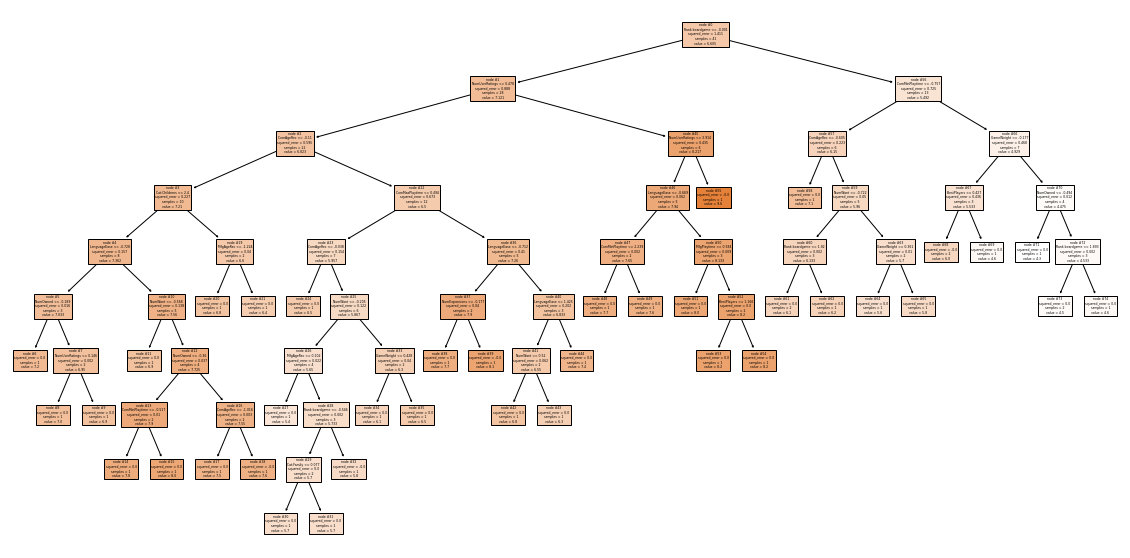

In [324]:
# Plot the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(tree_regressor, filled=True, feature_names=X.columns,node_ids=True)
plt.show()

In [213]:
# calculate feature importances for a prediction

# select features used to create a prediction
decision_path = tree_regressor.decision_path([test_X.iloc[5,:]])
node_indices = decision_path.indices
feature_indices = tree_regressor.tree_.feature
feature_names = test_X.columns  # Replace with your actual feature names
used_features = [feature_names[i] for i in feature_indices[node_indices] if i > 0]
used_features

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


['Rank:partygames',
 'NumWant',
 'ComMinPlaytime',
 'GameWeight',
 'ComAgeRec',
 'BestPlayers']

In [327]:
def get_features_sorted(selected_featurenames, feature_names, feature_importances):
    # Create a list of tuples (feature_name, feature_importance)
    feature_importance_tuples = list(zip(feature_names, feature_importances))
    
    # Sort the list of tuples by feature importance in descending order
    sorted_features = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)
    sorted_features = [s for s in sorted_features if s[0] in selected_featurenames]
    return sorted_features

In [328]:
get_features_sorted(used_features, test_X.columns, tree_regressor.feature_importances_)

[('ComMinPlaytime', 0.08373706791644563),
 ('ComAgeRec', 0.0722695539980487),
 ('GameWeight', 0.034914502429109005),
 ('NumWant', 0.02520206107921588),
 ('BestPlayers', 0.022583627713000303),
 ('Rank:partygames', 0.0)]

In [222]:
test_items[['Name']+final_item_features].loc[1190274,:]

Name                   The Isle of Cats
rating                              7.0
LanguageEase                   3.214286
NumWant                             714
Cat:Strategy                          1
Cat:Family                            1
Cat:Childrens                         0
GameWeight                       2.3004
BestPlayers                           3
Rank:partygames                   21926
ComMinPlaytime                       60
Rank:childrensgames               21926
ComMaxPlaytime                       90
ComAgeRec                          8.45
MfgAgeRec                             8
Cat:Party                             0
MinPlayers                            1
Kickstarted                           1
Rank:strategygames                   78
NumUserRatings                    10611
NumOwned                          19171
MfgPlaytime                          90
NumExpansions                         8
Rank:boardgame                       98
item                             281259


In [209]:
node_indicator = decision_path
leaf_id = tree_regressor.apply([test_X.iloc[0,:]])
for node_id in node_indices:
    # continue to the next node if it is a leaf node
    # if leaf_id[sample_id] == node_id:
    #     continue
    if node_id==leaf_id:
        continue
    
    print(
        "decision node {node} : X_test[{sample},{feature}]".format(
            node=node_id,
            sample=node_id,
            feature=feature_indices[node_id],
        )
    )


decision node 0 : X_test[0,7]
decision node 2 : X_test[2,1]
decision node 3 : X_test[3,11]


### Showcase

In [307]:
user = random.sample(list(all_user_names), num_users_test)[0]
X, y = generate_Xy_for_user(user, user_item_all_features[final_item_features])
print(f"Username: {user} | Number of interactions: {X.shape[0]}")

Username: kaichi | Number of interactions: 52


In [315]:
# train a tree
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
tree_regressor.fit(train_X, train_y)
predicted_y = tree_regressor.predict(test_X)

item_ratings = test_y.to_frame().copy()
item_ratings['predicted'] = predicted_y
        
RMSE = ((item_ratings['rating']-item_ratings['predicted'])**2).mean(0)**0.5
MAE = (abs(item_ratings['rating']-item_ratings['predicted'])).mean(0)

interacted_items = user_item_complete[user_item_complete.index.isin(X.index)]
test_items = user_item_complete[user_item_complete.index.isin(test_X.index)]
important_features = ['Name']+final_item_features

In [329]:
def explain_prediction(item_data, test_X, tree_reg, k=3):
    """ will explain the recommendation using top k important features for the particular item"""
    item_id = item_data.name
    item_Name = item_data.Name
    test_ids = test_X.index
    if item_id not in test_ids:
        return "No such item in the test set"
    
    decision_path = tree_regressor.decision_path([test_X.loc[item_id,:]])
    node_indices = decision_path.indices
    feature_indices = tree_regressor.tree_.feature
    feature_names = test_X.columns  
    used_features = [feature_names[i] for i in feature_indices[node_indices] if i > 0]
    print(used_features)
    selected_features = get_features_sorted(used_features, feature_names, tree_regressor.feature_importances_)
    print(selected_features)
    
    explaining_fs = []
    for f in selected_features:
        if len(explaining_fs) <= k or f[1] != 0:
            explaining_fs.append(f[0])
    
        
    if len(explaining_fs):
        return f"The game '{item_Name}' is recommended to you because you like games in the following categories: {', '.join(explaining_fs)}"

In [332]:
item = test_items[important_features].sample(1).iloc[0]
explain_prediction(item, test_X, tree_regressor, k=3)

['Rank:boardgame', 'NumUserRatings', 'ComAgeRec', 'Cat:Childrens', 'NumWant']
[('Rank:boardgame', 0.4075881163292853), ('NumUserRatings', 0.1980936701628928), ('ComAgeRec', 0.0722695539980487), ('NumWant', 0.02520206107921588), ('Cat:Childrens', 0.01607787220409501)]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


"The game 'L.A.M.A. Party Edition' is recommended to you because you like games in the following categories: Rank:boardgame, NumUserRatings, ComAgeRec, NumWant, Cat:Childrens"